In [1]:
import os
import json
import glob
import numpy as np
import shap
import matplotlib.pyplot as plt
import pandas as pd

ROOT_DIR = './ids'

### analysis 1: feature importance with shap

In [2]:
def getExperiments(root_dir):
    experiments_list = []
    
    if not os.path.isdir(root_dir):
        print(f"Diretório raiz '{root_dir}' não encontrado.")
        return experiments_list

    ids = os.listdir(root_dir)

    for id_folder in ids:
        results_path = os.path.join(root_dir, id_folder, 'results')
        
        if os.path.isdir(results_path):
            datasets = os.listdir(results_path)

            for dataset in datasets:
                dataset_path = os.path.join(results_path, dataset)

                if os.path.isdir(dataset_path):
                    experiments = os.listdir(dataset_path)

                    for experiment in experiments:
                        experiment_path = os.path.join(dataset_path, experiment)
                        
                        if os.path.isdir(experiment_path):
                            experiments_list.append({
                                'ids': id_folder,
                                'dataset': dataset,
                                'type': experiment,
                                'path': experiment_path
                            })
    return experiments_list

In [3]:
experiments = getExperiments(ROOT_DIR)


--- Project: ocpp-ids | Dataset: ocppflowmeter | Exp: baseline ---
  -> Generating outputs for Exp: baseline
    -> Feature ranking saved to ./ids/ocpp-ids/results/ocppflowmeter/baseline/shap/shap_ranking.json


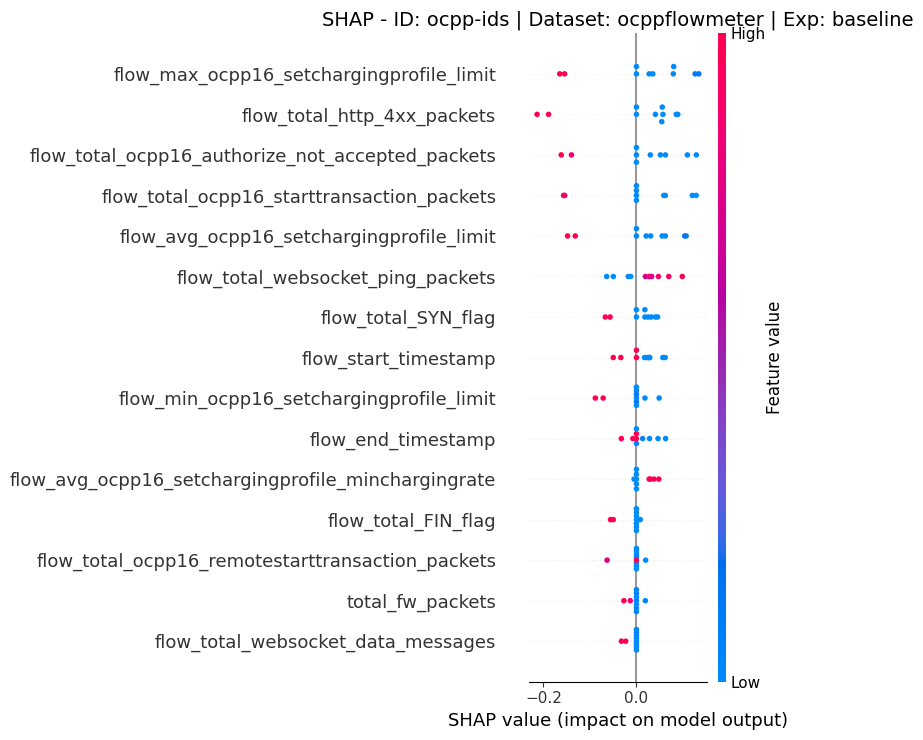


--- Project: ocpp-ids | Dataset: cicflowmeter | Exp: baseline ---
  -> Generating outputs for Exp: baseline
    -> Feature ranking saved to ./ids/ocpp-ids/results/cicflowmeter/baseline/shap/shap_ranking.json


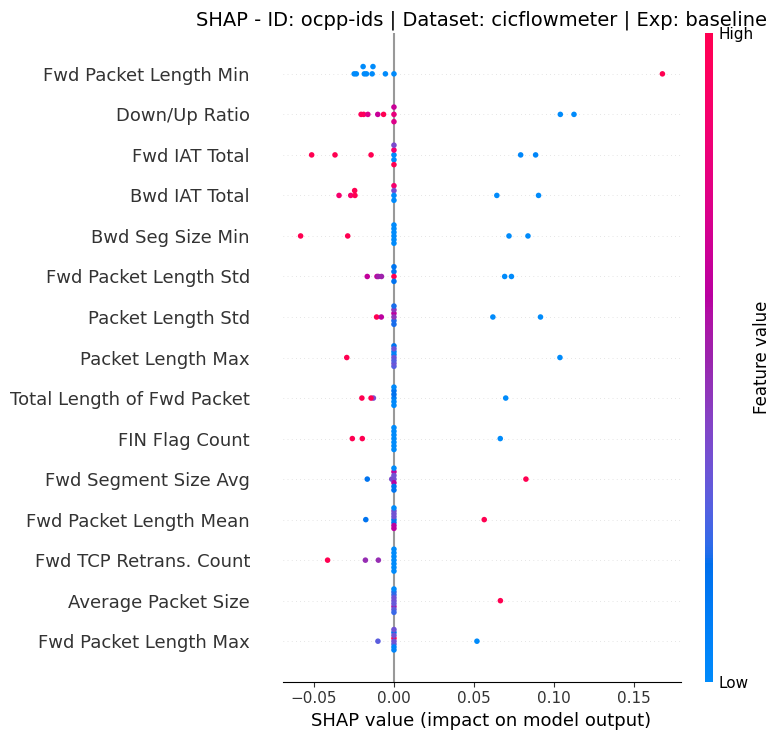

In [49]:
for exp in experiments:
    if exp['type'] != 'baseline':
        continue
    
    print(f"\n--- Project: {exp['ids']} | Dataset: {exp['dataset']} | Exp: {exp['type']} ---")
    shap_file = os.path.join(exp['path'], 'shap', 'shap_values.npy')

    if not os.path.exists(shap_file):
        print("  -> No SHAP file found for this experiment.")
        continue
    
    try:
        shap_dir = os.path.dirname(shap_file)
        data_file = os.path.join(shap_dir, 'shap_data.npy')
        features_file = os.path.join(shap_dir, 'shap_features.json')
        class_names_file = os.path.join(shap_dir, 'shap_class_names.json')

        shap_values = np.load(shap_file, allow_pickle=True)
        data_samples = np.load(data_file, allow_pickle=True)
        
        with open(features_file, 'r') as f:
            feature_data = json.load(f)
            if isinstance(feature_data, dict):
                feature_names = feature_data.get('feature_names', [])
            else:
                feature_names = feature_data

        class_names = None
        if os.path.exists(class_names_file):
            with open(class_names_file, 'r') as f:
                class_data = json.load(f)
                if isinstance(class_data, dict):
                    class_names = class_data.get('class_names')
                else:
                    class_names = class_data
        
        print(f"  -> Generating outputs for Exp: {exp['type']}")
        
        if shap_values.ndim == 3 and shap_values.shape[2] == 1:
            shap_values_to_plot = shap_values[:, :, 0]
        else:
            shap_values_to_plot = shap_values
        
        mean_abs_shap = np.abs(shap_values_to_plot).mean(axis=0)
        sorted_idx = np.argsort(mean_abs_shap)
        sorted_features_shap_asc = [feature_names[i] for i in sorted_idx]
        
        plots_path = os.path.join(os.getcwd(), 'notebooks', 'plots', exp['ids'])
        os.makedirs(plots_path, exist_ok=True)
        
        out_file = os.path.join(exp['path'], 'shap', 'shap_ranking.json')
        with open(out_file, 'w') as f:
            json.dump(sorted_features_shap_asc, f, indent=2)
        print(f"    -> Feature ranking saved to {out_file}")

        plt.figure()
        shap.summary_plot(
            shap_values_to_plot, 
            data_samples, 
            feature_names=feature_names, 
            class_names=class_names,
            show=False, 
            max_display=15
        )
        
        plt.title(f"SHAP - ID: {exp['ids']} | Dataset: {exp['dataset']} | Exp: {exp['type']}", fontsize=14)
        plt.tight_layout()
        plt.savefig(os.path.join(plots_path, f"shap_{exp['type']}_{exp['dataset']}.png"))
        plt.show()

    except Exception as e:
        print(f"    WARNING: Failed to process {shap_file}. Error: {e}")

### LIME vs SHAP

In [50]:
def plot_lime_importance(file_path, title_prefix, plots_path, n_features=None):
    if not os.path.exists(file_path):
        return False

    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
    except json.JSONDecodeError:
        return False
    except Exception as e:
        return False

    if not isinstance(data, dict):
        return False
    
    df = pd.DataFrame(list(data.items()), columns=['Feature', 'Importance'])
    df['Magnitude'] = df['Importance'].abs()

    df_sorted = df.sort_values(by='Magnitude', ascending=False)
    
    if n_features is not None and n_features > 0:
        df_sorted = df_sorted.head(n_features)
    
    df_sorted = df_sorted.iloc[::-1]

    features = df_sorted['Feature'].tolist()
    importances = df_sorted['Importance'].tolist()

    fig, ax = plt.subplots(figsize=(10, len(features) * 0.45))

    colors = ['firebrick' if val < 0 else 'dodgerblue' for val in importances]
    
    ax.barh(features, importances, color=colors, edgecolor='black', linewidth=0.5)
    
    ax.axvline(0, color='black', linestyle='-', linewidth=1)

    ax.set_title(f"LIME Feature Importance - {title_prefix}", fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel("Contribuição da Feature (Peso)", fontsize=14, fontweight='bold')
    ax.set_ylabel("Feature", fontsize=14, fontweight='bold')
    
    ax.set_yticks(range(len(features)))
    ax.set_yticklabels(features, fontsize=10, fontweight='bold')
    
    ax.tick_params(axis='x', labelsize=12)

    ax.xaxis.grid(True, linestyle='--', alpha=0.7) 
    ax.yaxis.grid(False) 
    
    ax.set_ylim(-0.5, len(features) - 0.5)
    
    fig.tight_layout()
    
    file_suffix = f"_top_{n_features}" if n_features is not None and n_features > 0 else "_all"
    file_name = f"lime_importance_plot_{title_prefix.replace(' | ', '_').replace('ID: ', '').replace('Dataset: ', '').replace('Exp: baseline', 'baseline')}{file_suffix}.png"
    
    plt.savefig(os.path.join(plots_path, file_name), dpi=300, bbox_inches='tight')
    plt.show()
    return True

def transformLIME(input_file_path):
    if not os.path.exists(input_file_path):
        print(f"Error: Input file '{input_file_path}' not found.")
        return False
        
    try:
        with open(input_file_path, 'r') as f:
            data = json.load(f)
    except json.JSONDecodeError:
        print(f"Error: File '{input_file_path}' is not a valid JSON.")
        return False
    except Exception as e:
        print(f"Error reading file: {e}")
        return False

    if not isinstance(data, dict):
        print("Error: The JSON content is not a dictionary.")
        return False

    keys_list = list(data.keys())

    input_dir = os.path.dirname(input_file_path)
    output_file_path = os.path.join(input_dir, 'lime_ranking.json')

    try:
        with open(output_file_path, 'w') as f:
            json.dump(keys_list, f, indent=2)
        print(f"Success: Keys list saved to '{output_file_path}'")
        return True
    except Exception as e:
        print(f"Error writing file: {e}")
        return False


--- Project: ocpp-ids | Dataset: ocppflowmeter | Exp: baseline ---
Success: Keys list saved to './ids/ocpp-ids/results/ocppflowmeter/baseline/lime/lime_ranking.json'


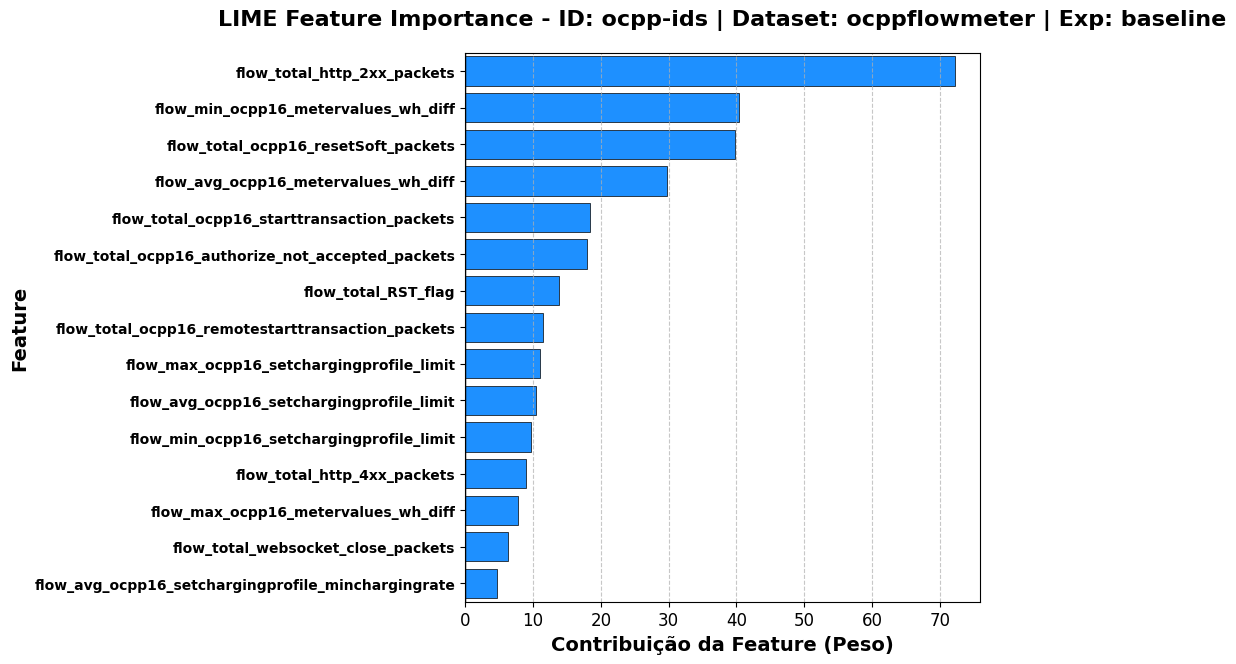


Starting feature position comparison...


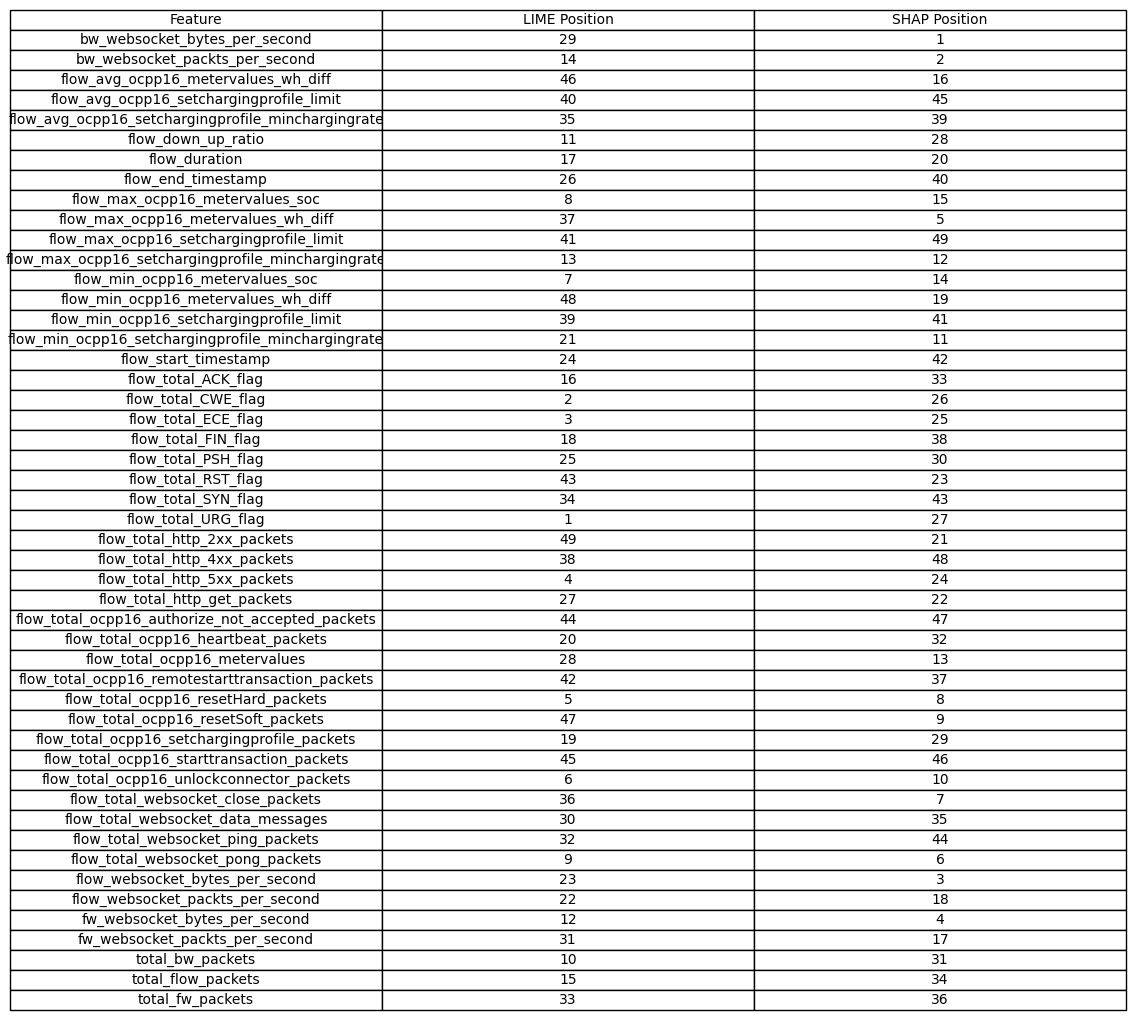


--- Project: ocpp-ids | Dataset: cicflowmeter | Exp: baseline ---
Success: Keys list saved to './ids/ocpp-ids/results/cicflowmeter/baseline/lime/lime_ranking.json'


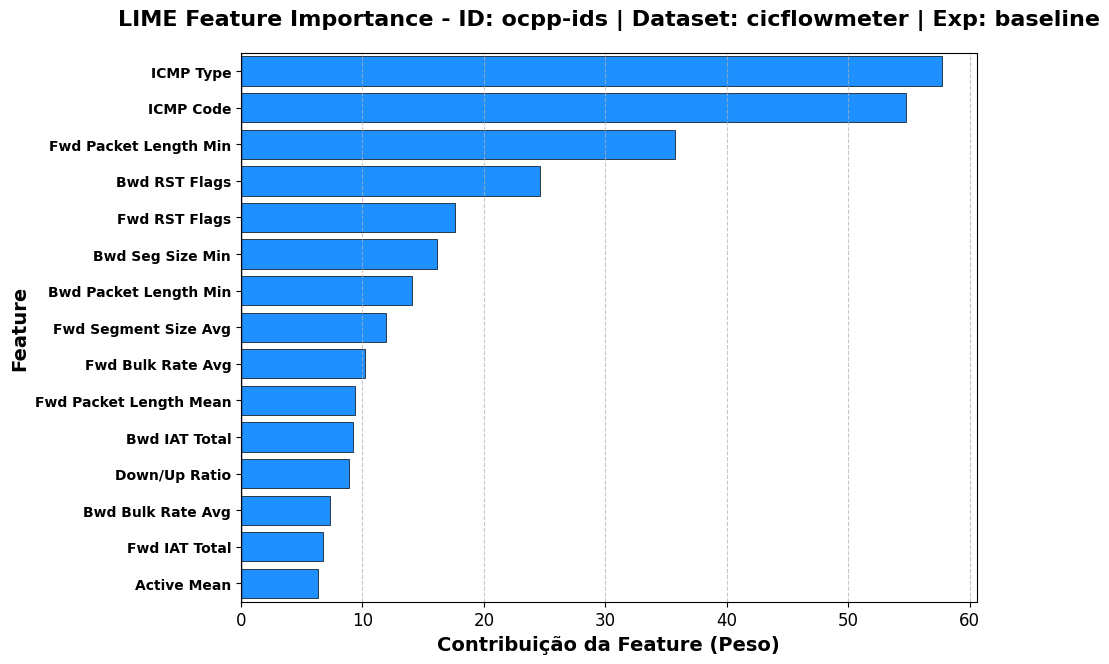


Starting feature position comparison...


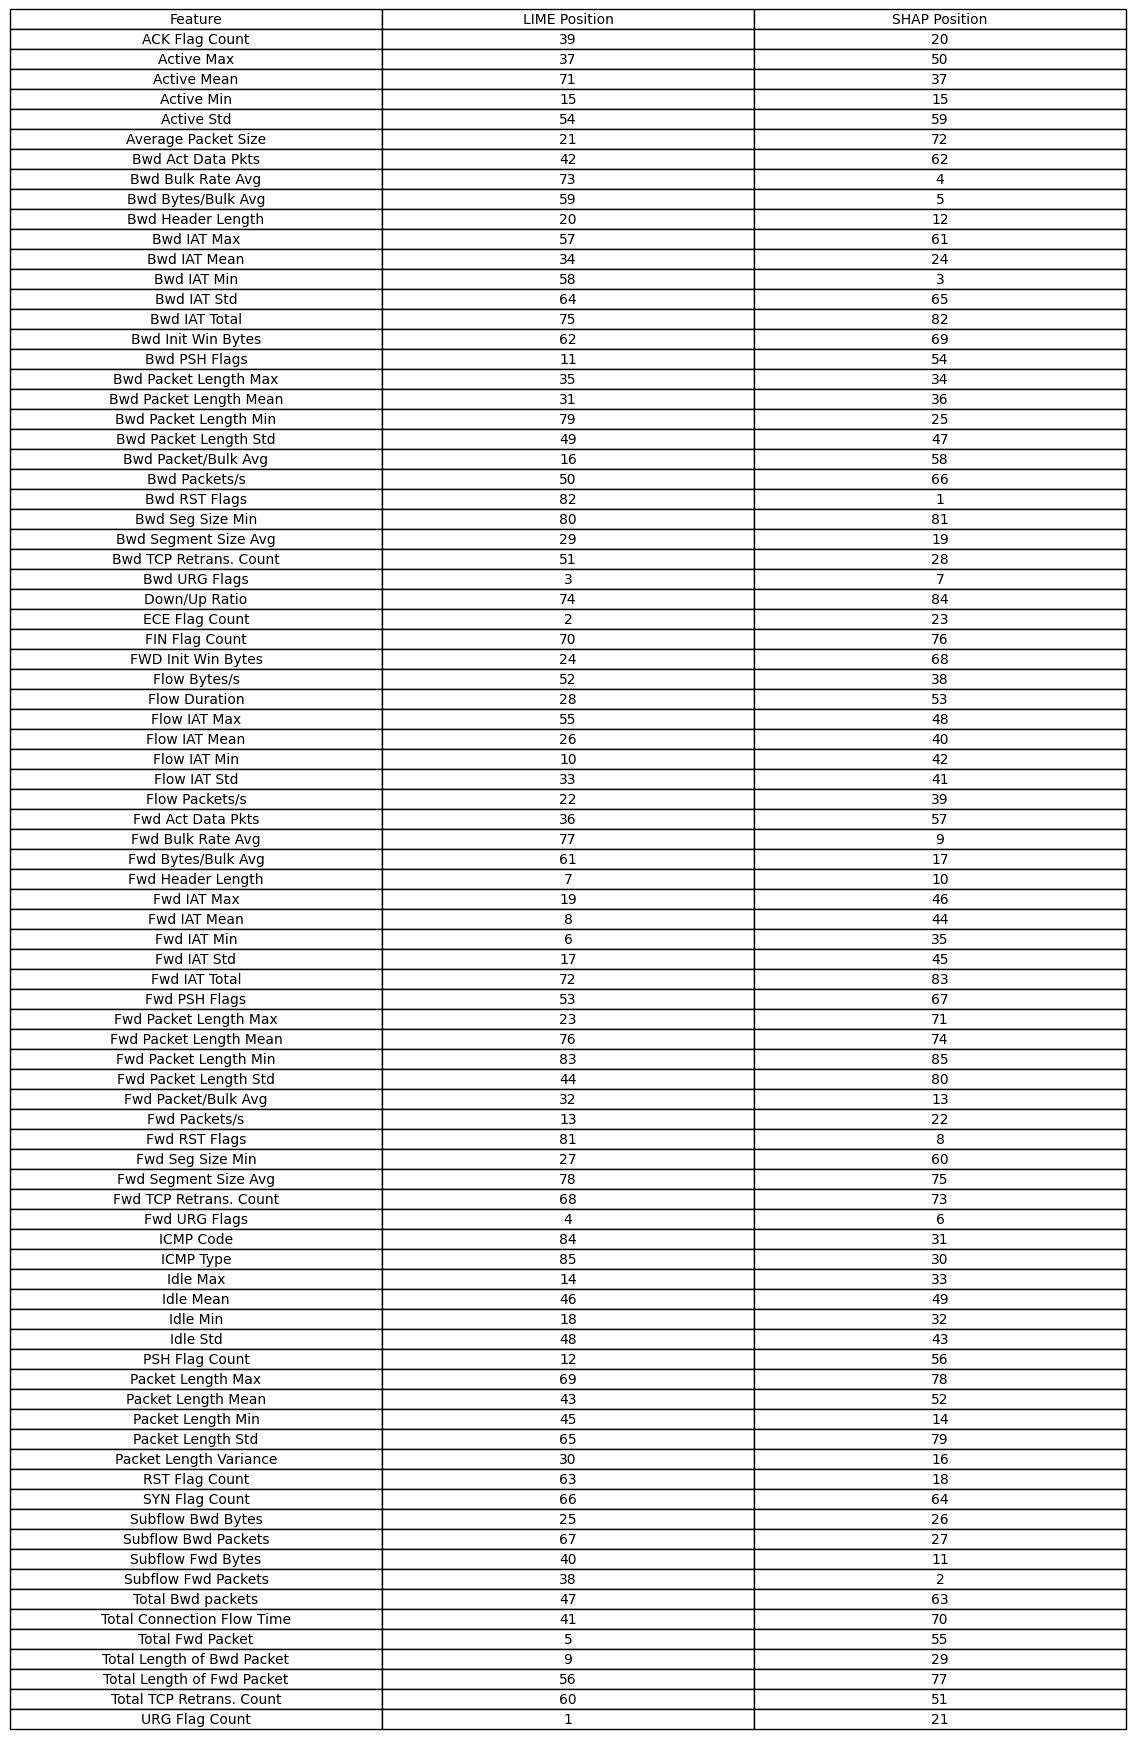

In [52]:
for exp in experiments:
    if exp['type'] != 'baseline':
        continue
    
    print(f"\n--- Project: {exp['ids']} | Dataset: {exp['dataset']} | Exp: {exp['type']} ---")
    
    lime_json_path = os.path.join(exp['path'], 'lime', 'lime_feature_importance.json')
    
    transformLIME(lime_json_path)

    lime_ranking_file = os.path.join(os.path.dirname(lime_json_path), 'lime_ranking.json')
    plots_path = os.path.join(os.getcwd(), 'notebooks', 'plots', exp['ids'])
    os.makedirs(plots_path, exist_ok=True)  

    title = f"ID: {exp['ids']} | Dataset: {exp['dataset']} | Exp: {exp['type']}"
    
    plot_lime_importance(lime_json_path, title, plots_path, n_features=15)
    
    file_path_1 = os.path.join(exp['path'], 'lime', 'lime_ranking.json')
    file_path_2 = os.path.join(exp['path'], 'shap', 'shap_ranking.json')
    
    if not os.path.exists(file_path_1) or not os.path.exists(file_path_2):
        print("Error: One or both files were not found. Skipping comparison.")
    else:
        try:
            with open(file_path_1, 'r') as f1, open(file_path_2, 'r') as f2:
                data1 = json.load(f1)
                data2 = json.load(f2)
                
            if not isinstance(data1, list) or not isinstance(data2, list):
                print("Error: The content of one or both files is not a list. Skipping comparison.")
            else:
                print("\nStarting feature position comparison...")

                lime_positions = {feature: i + 1 for i, feature in enumerate(data1)}
                shap_positions = {feature: i + 1 for i, feature in enumerate(data2)}

                all_features = sorted(list(set(lime_positions.keys()) | set(shap_positions.keys())))
                
                comparison_data = []
                for feature in all_features:
                    pos_lime = lime_positions.get(feature, "N/A")
                    pos_shap = shap_positions.get(feature, "N/A")
                    comparison_data.append([feature, pos_lime, pos_shap])
                
                comparison_df = pd.DataFrame(comparison_data, columns=['Feature', 'LIME Position', 'SHAP Position'])

                fig, ax = plt.subplots(figsize=(12, 8))
                ax.axis('off')
                table = ax.table(cellText=comparison_df.values, colLabels=comparison_df.columns, cellLoc='center', loc='center')
                
                table.auto_set_font_size(False)
                table.set_fontsize(10)
                table.scale(1.2, 1.2)

                plots_path = os.path.join(os.getcwd(), 'notebooks', 'plots', exp['ids'])
                plt.savefig(os.path.join(plots_path, f"comparison_table_{exp['ids']}_{exp['dataset']}.png"))
                plt.show()

        except json.JSONDecodeError:
            print("Error: One of the files is not a valid JSON. Skipping comparison.")
        except Exception as e:
            print(f"Unexpected error: {e}. Skipping comparison.")

In [72]:
def get_model_size_mb(exp_list):
    model_sizes = []
    
    for exp in exp_list:
        model_path = os.path.join(exp['path'], 'model.h5')
        
        size_mb = 0
        if os.path.exists(model_path):
            try:
                # O tamanho é dado em bytes. Converte para Megabytes (1024 * 1024)
                size_bytes = os.path.getsize(model_path)
                size_mb = size_bytes / (1024 * 1024)
            except Exception as e:
                print(f"Error getting size for {model_path}: {e}")
        
        model_sizes.append({
            'ids': exp['ids'],
            'dataset': exp['dataset'],
            'experiment_type': exp['type'],
            'model_size_mb': size_mb
        })
        
    return pd.DataFrame(model_sizes)

def get_latest_metrics(exp_list):
    all_metrics = []
    
    for exp in exp_list:
        metrics_path = os.path.join(exp['path'], f"{exp['type']}.csv")
        
        if os.path.exists(metrics_path):
            try:
                df = pd.read_csv(metrics_path)
                
                last_row = df.iloc[-1].to_dict()
                
                start_time_str = df.iloc[0]['timestamp']
                end_time_str = df.iloc[-1]['timestamp']
                
                start_time = pd.to_datetime(start_time_str)
                end_time = pd.to_datetime(end_time_str)
                
                duration_minutes = (end_time - start_time).total_seconds() / 60
                
                experiment_info = {
                    'ids': exp['ids'],
                    'dataset': exp['dataset'],
                    'experiment_type': exp['type'],
                    'duration_minutes': duration_minutes,
                    'accuracy': last_row['accuracy'],
                    'precision': last_row['weighted avg_precision'],
                    'recall': last_row['weighted avg_recall'],
                    'f1_score': last_row['weighted avg_f1_score']
                }
                all_metrics.append(experiment_info)
                
            except Exception as e:
                print(f"Error processing {metrics_path}: {e}")
                
    return pd.DataFrame(all_metrics)

def plot_all_experiments_grouped(df, metric, title_prefix, plots_path, xlabel_text=None, width=0.4):
    fig, ax = plt.subplots(figsize=(10, 7))

    experiments_df = df[df['experiment_type'] != 'baseline'].copy()
    baseline_df = df[df['experiment_type'] == 'baseline']
    
    try:
        experiments_df['sort_key'] = experiments_df['experiment_type'].apply(lambda x: int(x.split('_')[-1]))
    except:
        experiments_df['sort_key'] = experiments_df['experiment_type']
    
    lime_df = experiments_df[experiments_df['experiment_type'].str.contains('lime_')].sort_values('sort_key')
    shap_df = experiments_df[experiments_df['experiment_type'].str.contains('shap_')].sort_values('sort_key')
    
    grouped_labels = [exp.split('_')[-1] for exp in lime_df['experiment_type']]
    grouped_x = np.arange(len(grouped_labels))

    bar1 = ax.bar(grouped_x - width/2, lime_df[metric], width, label='LIME', color='orange', edgecolor='black', linewidth=0.5)
    bar2 = ax.bar(grouped_x + width/2, shap_df[metric], width, label='SHAP', color='teal', edgecolor='black', linewidth=0.5)

    if metric == 'model_size_mb' or metric == 'duration_minutes':
        fmt_str = '%.3f'
    else:
        fmt_str = '%.7f' 
    # ------------------------------------
        
    ax.bar_label(bar1, padding=3, fmt=fmt_str, fontsize=12, fontweight='bold') 
    ax.bar_label(bar2, padding=3, fmt=fmt_str, fontsize=12, fontweight='bold') 

    all_values_for_ylim = experiments_df[metric].tolist()

    if not baseline_df.empty:
        baseline_value = baseline_df[metric].iloc[0]
        if metric == 'model_size_mb':
            baseline_label = f'Baseline ({baseline_value:.3f})'
        else:
            baseline_label = f'Baseline ({baseline_value:.7f})' 
            
        ax.axhline(y=baseline_value, color='dimgray', linestyle='--', linewidth=2, label=baseline_label)
        all_values_for_ylim.append(baseline_value)
    
    #ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=16, fontweight='bold') 
    #ax.set_title(f"{title_prefix} - {metric.replace('_', ' ').title()}", fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(grouped_x)
    
    ax.set_xticklabels(grouped_labels, fontsize=14) 
    ax.tick_params(axis='y', labelsize=12) 
    ax.set_yticklabels([]) 

    if xlabel_text:
        ax.set_xlabel(xlabel_text, fontsize=14, fontweight='bold')

    ax.legend(fontsize=12)

    min_val = min(all_values_for_ylim)
    max_val = max(all_values_for_ylim)
    range_val = max_val - min_val
    if range_val == 0:
        range_val = min_val * 0.01 if min_val > 0 else 0.01

    ax.set_ylim(bottom=min_val - (range_val * 0.1), top=max_val + (range_val * 0.2))

    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)

    fig.tight_layout()
    
    file_name = f"graph_{df.iloc[0]['ids']}_{df.iloc[0]['dataset']}_{metric}.png"
    plt.savefig(os.path.join(plots_path, file_name), dpi=300, bbox_inches='tight')
    
    plt.show()


--- Generating grouped plots for ID: ocpp-ids | Dataset: cicflowmeter ---


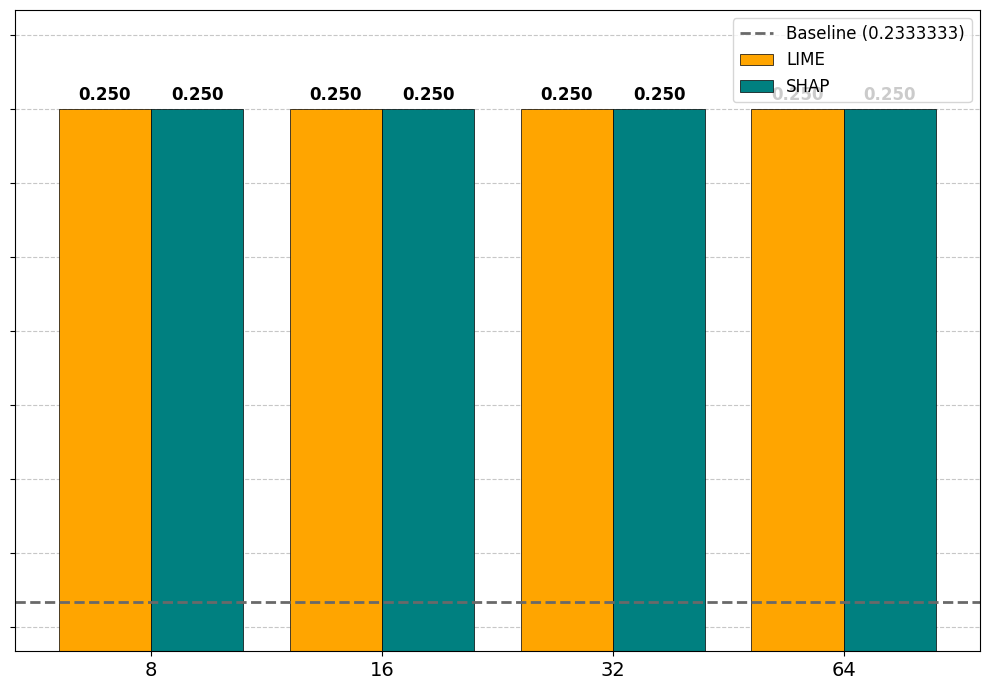

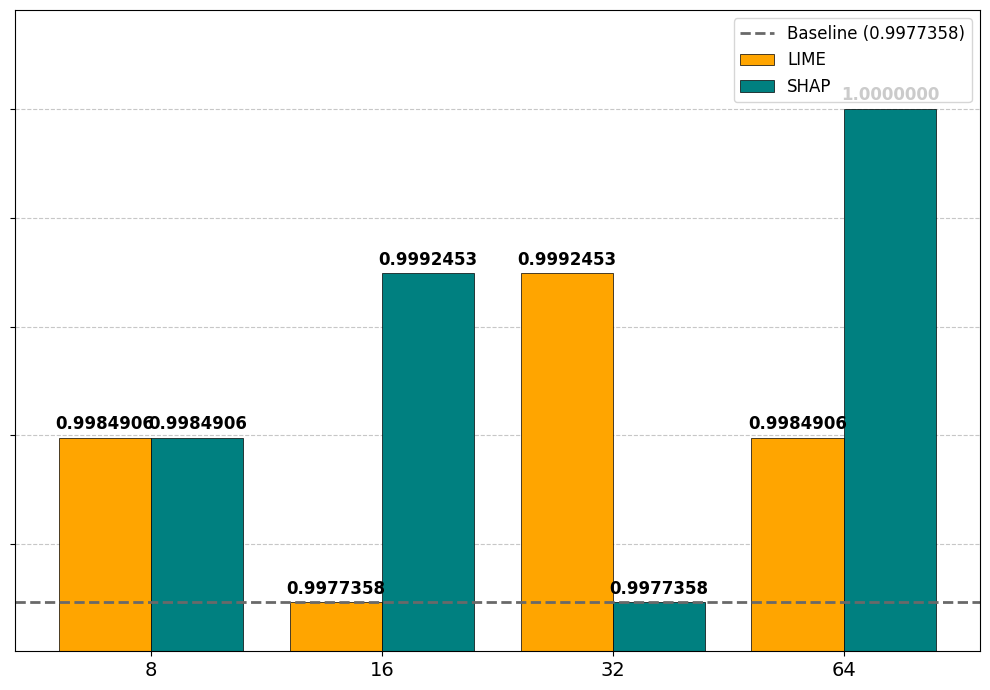

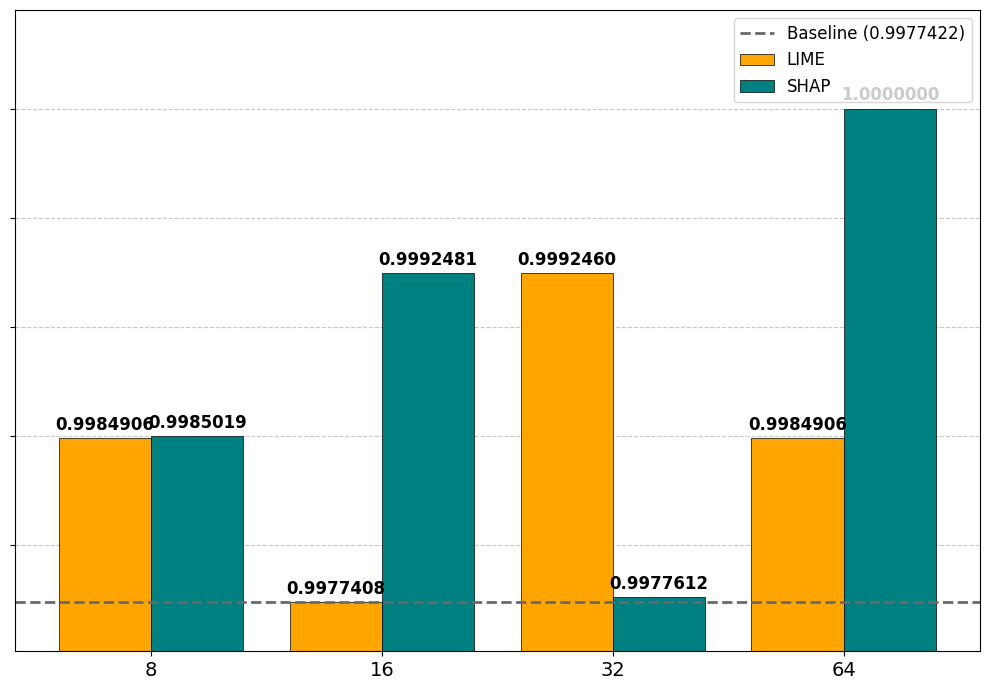

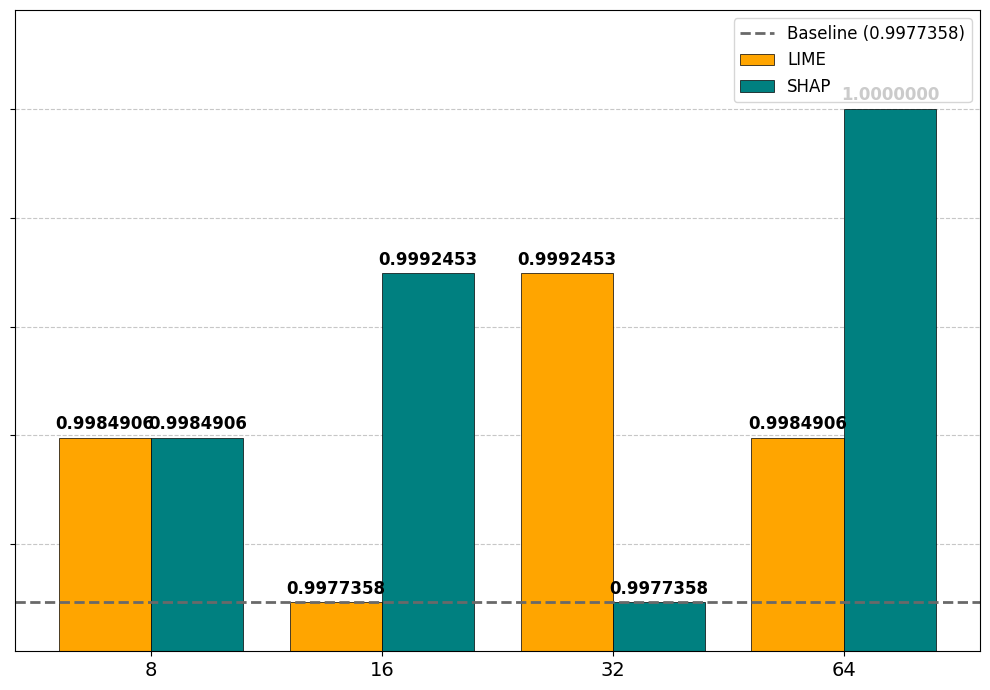

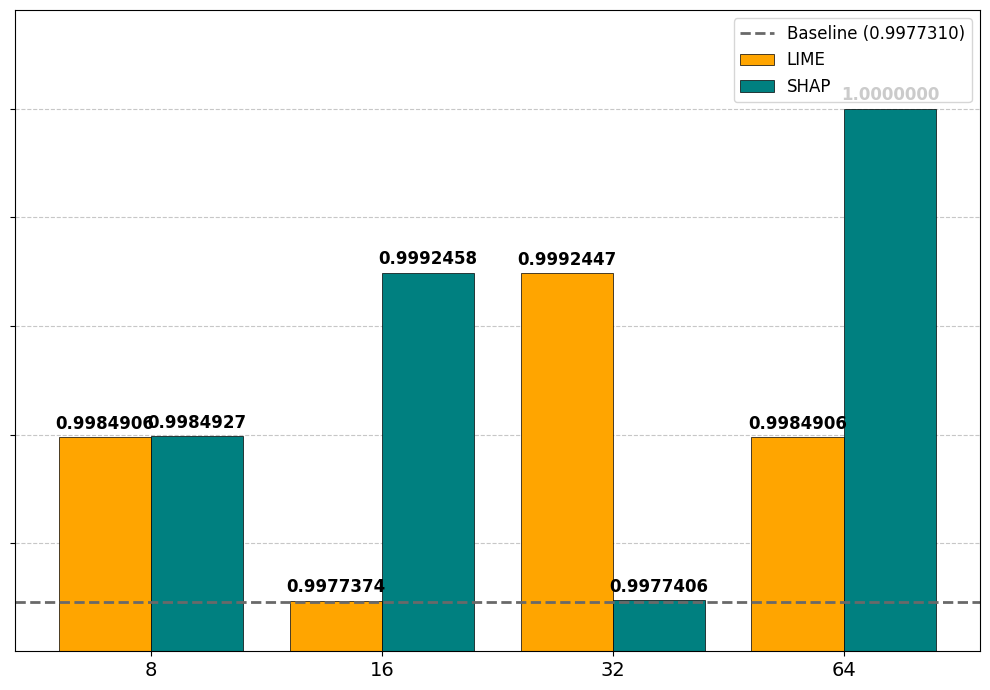

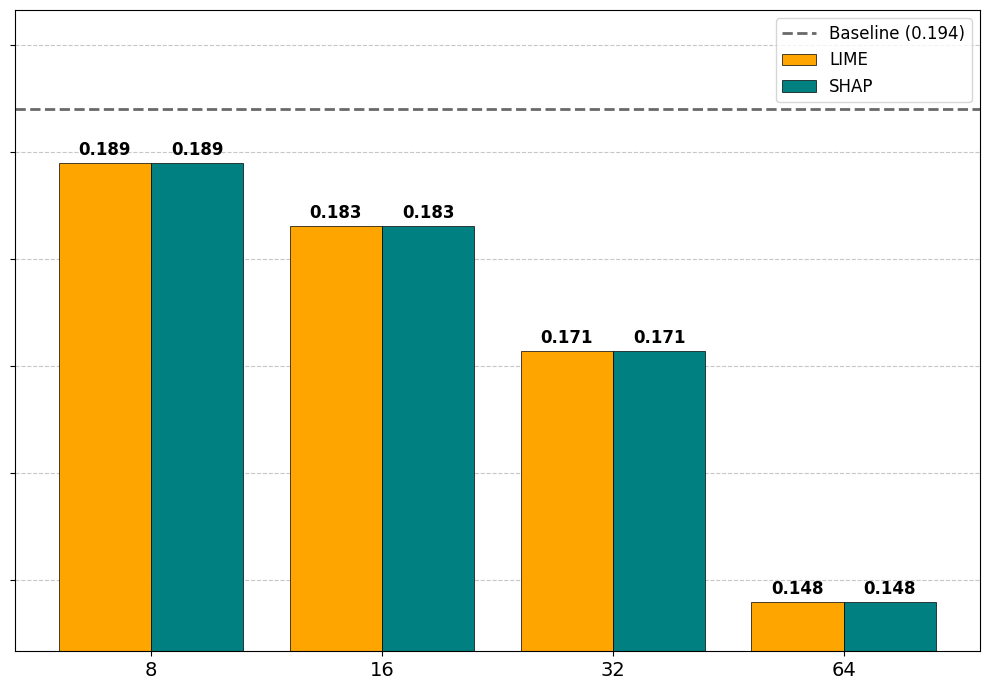


--- Generating grouped plots for ID: ocpp-ids | Dataset: ocppflowmeter ---


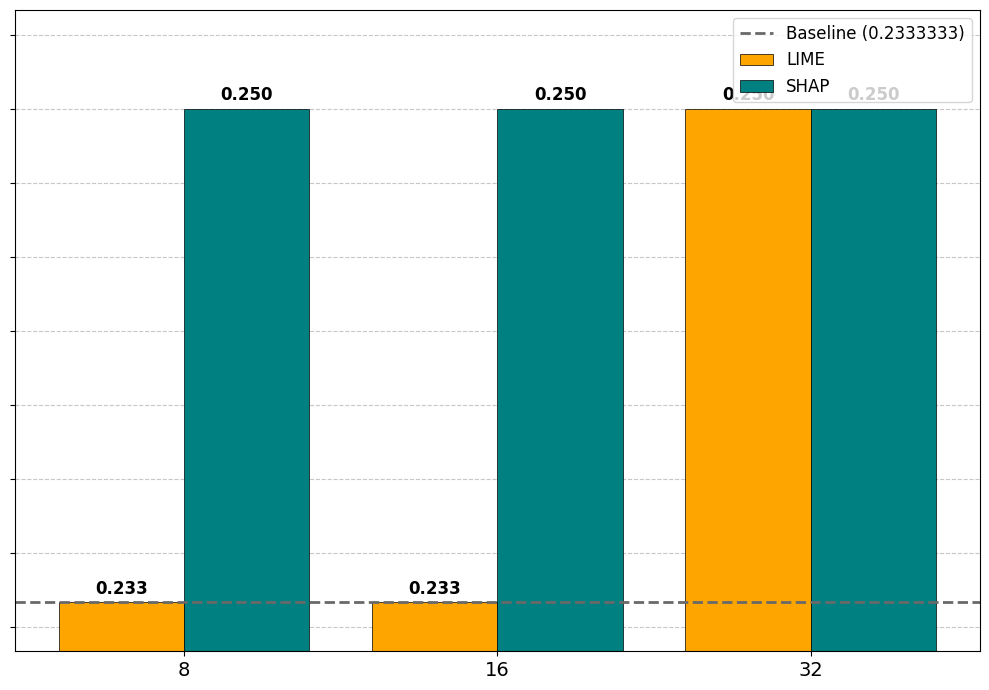

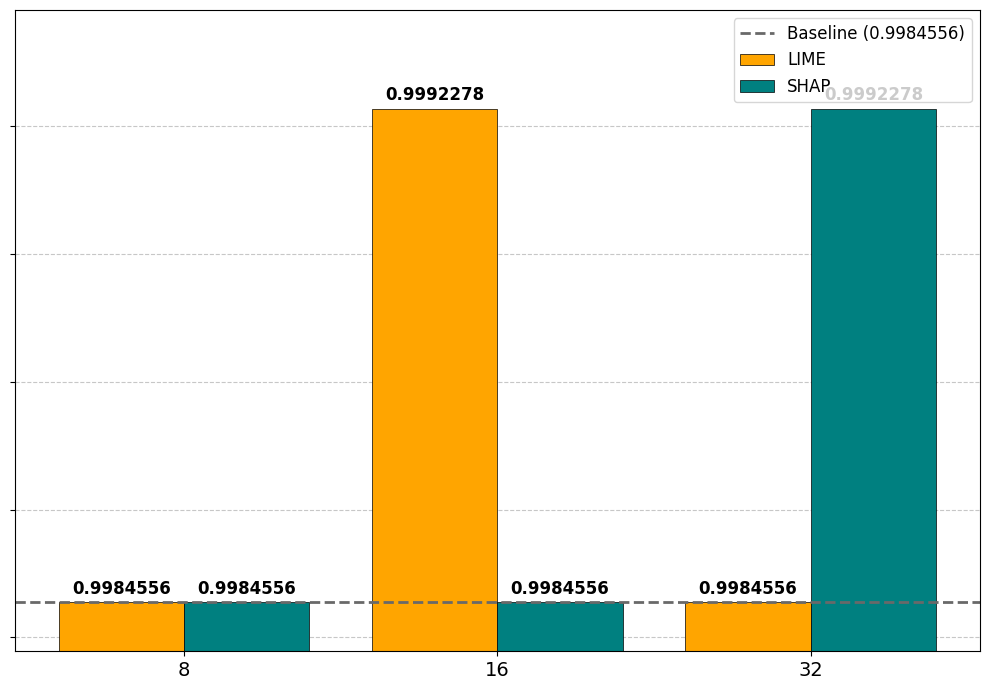

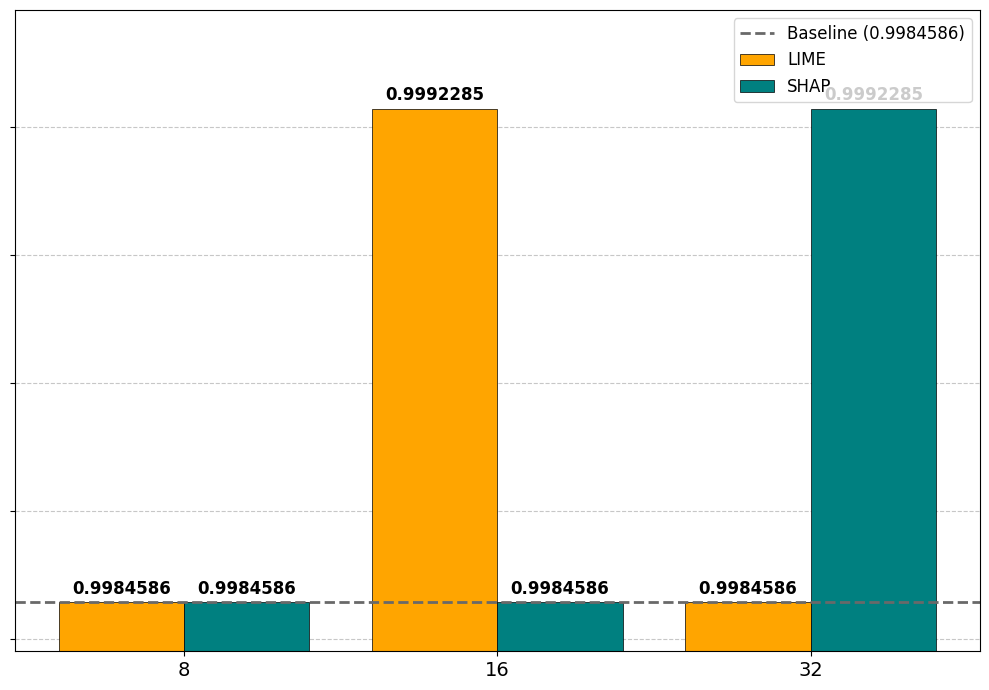

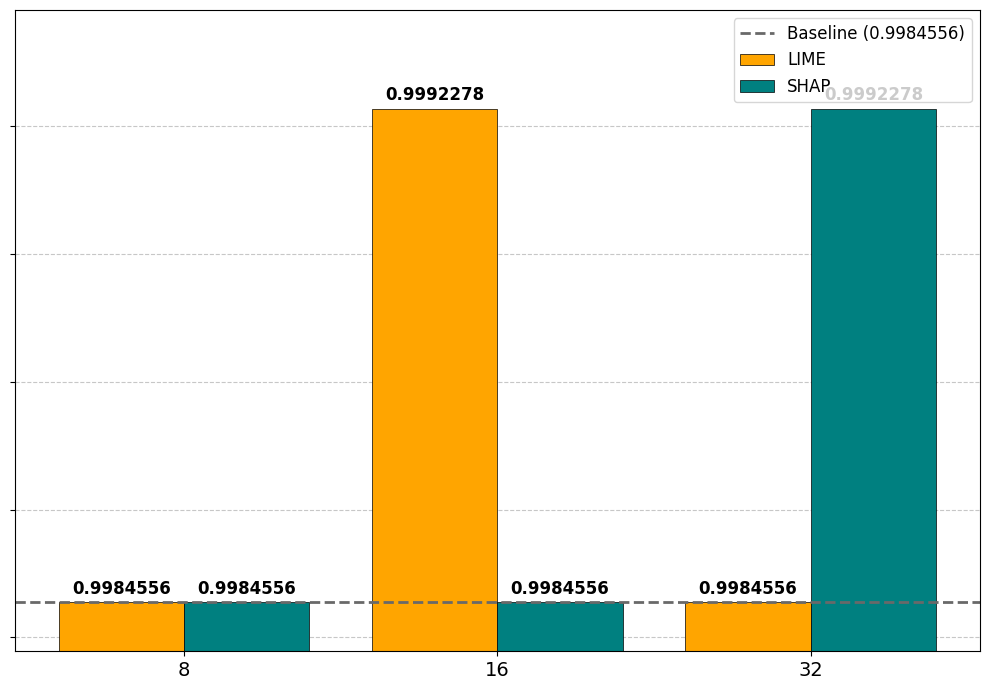

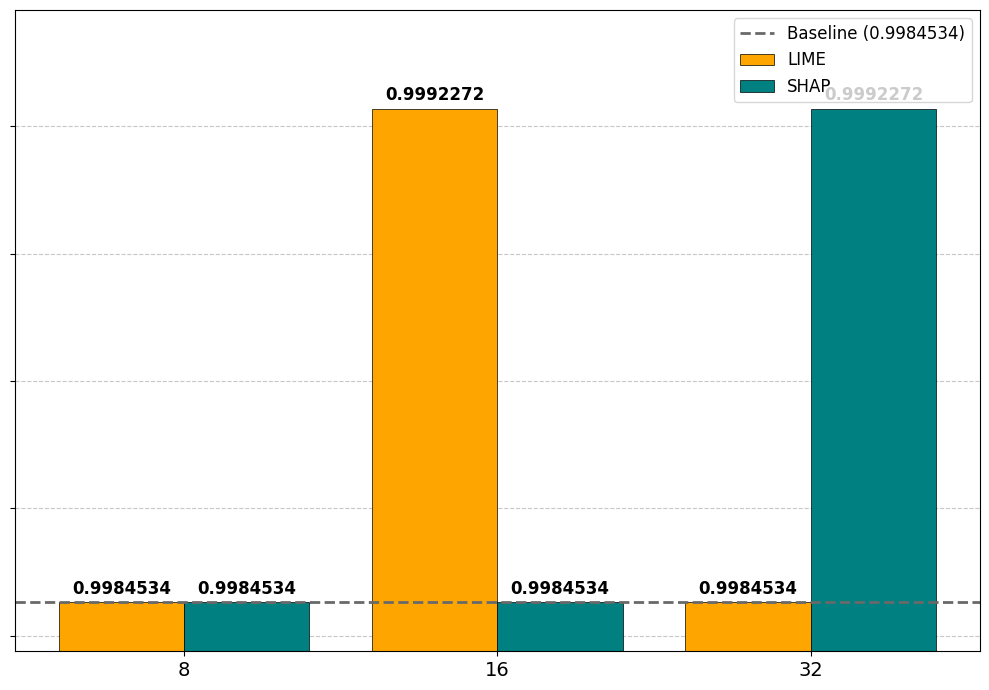

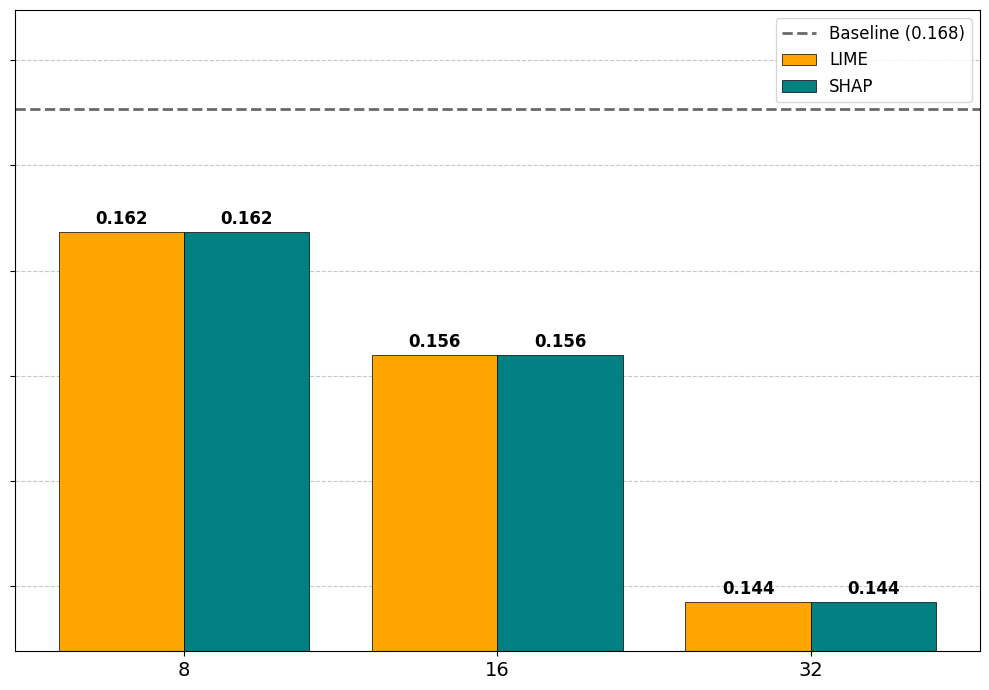

In [73]:
metrics_df = get_latest_metrics(experiments)
model_sizes_df = get_model_size_mb(experiments)
combined_df = pd.merge(metrics_df, model_sizes_df, 
                       on=['ids', 'dataset', 'experiment_type'], 
                       how='outer')

grouped = combined_df.groupby(['ids', 'dataset'])

for name, group in grouped:
    ids_name, dataset_name = name
    
    print(f"\n--- Generating grouped plots for ID: {ids_name} | Dataset: {dataset_name} ---")

    plots_path = os.path.join(os.getcwd(), 'notebooks', 'plots', ids_name)
    os.makedirs(plots_path, exist_ok=True)
    
    title = f"ID: {ids_name} | Dataset: {dataset_name}"
    
    plot_all_experiments_grouped(group, 'duration_minutes', title, plots_path)
    plot_all_experiments_grouped(group, 'accuracy', title, plots_path)
    plot_all_experiments_grouped(group, 'precision', title, plots_path)
    plot_all_experiments_grouped(group, 'recall', title, plots_path)
    plot_all_experiments_grouped(group, 'f1_score', title, plots_path)
    plot_all_experiments_grouped(group, 'model_size_mb', title, plots_path)